In [24]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation,TimeslotRepresentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from flowprintOptimal.sekigo.flowUtils.flowDatasets import PacketFlowDataset, BaseFlowDataset, DDQNActivityDataset
from torch.utils.data import Dataset,DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from joblib import Parallel, delayed
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.dataGetterV2 import readTrainTestOODFlows
from sklearn.metrics import confusion_matrix
import json
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D, LSTMDuelingNetwork
from flowprintOptimal.sekigo.modeling.loggers import Logger
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.utils.documentor import Documenter
from flowprintOptimal.sekigo.utils.evaluations import Evaluator,EarlyEvaluation
import warnings
from copy import deepcopy
import torch.nn as nn



warnings.filterwarnings('ignore')

In [25]:
configs = dict(
    name = "unibs_timeslot_ood",
    description = "unibs balanced datagettter V2 with OOD",
    
    common_config = dict(
        max_timesteps = 15,
        min_timesteps = 8
    ),
    
    full_model_kwargs = dict(
        lstm_hidden_size = 256,
        layers= 2, lstm_input_size = 3
    ),

    early_model_kwargs = dict(
        lstm_input_size= 3,lstm_hidden_size= 256,layers = 2                    
    ),
    
    data_config = dict(
        dataset_name = "unibs",
        subsampleConfig = None,#dict(max_gap = 20, min_gap = 5),                             
        max_flow_length = 100, # in seconds  ( each flow sample cannot excede this length)
        test_size = .2,
        ood_classes = ["hello"],
        do_balance = False,
        data_type = "timeslot_representation"

    ),

    rewarder_config = dict(
        l = .5
    ),

    dataset_config = dict(
        aug = [0,.2]
    ),

    memory_fillter_config = dict(
        ood_config = dict(ood_aug = [.6,.9], ood_prob = .2),
        min_length = 1,
        use_balancer = False
    ),
    full_trainer_config = dict(
        use_sampler = False
    ),
    early_trainer_config = dict(
        use_sampler = False  # this is for giving more weight to wait samples
    )

)

In [26]:
"""
# code to read and save packet flow reps UTMobileNet2021
utc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")
flows = utc_mobile_processor.processData()
saveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)
"""

'\n# code to read and save packet flow reps UTMobileNet2021\nutc_mobile_processor = UTMobileNetProcessor(base_path= "data/UTMobileNet2021")\nflows = utc_mobile_processor.processData()\nsaveFlows(path  = "data/UTMobileNet2021/mobilenetPacketRep.json", flows = flows)\n'

In [27]:
#train_flows, test_flows = loadFlows("Splits/Cls/UNIBS/train_flows.pkl", PacketFlowRepressentation), loadFlows("Splits/Cls/UNIBS/test_flows.pkl", PacketFlowRepressentation)
#ood_flows = []

In [28]:
#train_flows,test_flows,ood_flows = getTrainTestOOD(**configs["data_config"], max_timesteps= configs["common_config"]["max_timesteps"],
#                                                   min_timesteps= configs["common_config"]["min_timesteps"]
#                                                   )

In [29]:
if len(configs["data_config"]["ood_classes"]) == 0:
    base_dir_path = "data/ClassificationOnlyFlows"
else:
    base_dir_path = "data/ClassificationOODFlows"

In [30]:
def readTrainTestOODFlows(base_path, dataset_name):
    dir_path = os.path.join(base_path,dataset_name)
    print(dir_path)
    train_packet_flows = loadFlows(path= os.path.join(dir_path,"train_packet_flows.pkl"), cls= PacketFlowRepressentation)
    test_packet_flows = loadFlows(path= os.path.join(dir_path,"test_packet_flows.pkl"), cls= PacketFlowRepressentation)
    train_timeslot_flows = loadFlows(path= os.path.join(dir_path,"train_timeslot_flows.pkl"), cls= TimeslotRepresentation)
    test_timeslot_flows = loadFlows(path= os.path.join(dir_path,"test_timeslot_flows.pkl"), cls= TimeslotRepresentation)

    ood_packet_flows = []
    ood_timeslot_flows = []
    if os.path.exists(os.path.join(dir_path,"ood_packet_flows.pkl")):
        ood_packet_flows = loadFlows(path= os.path.join(dir_path,"ood_packet_flows.pkl"), cls= PacketFlowRepressentation)
        ood_timeslot_flows = loadFlows(path= os.path.join(dir_path,"ood_timeslot_flows.pkl"), cls= TimeslotRepresentation)




    return train_packet_flows,test_packet_flows,ood_packet_flows, train_timeslot_flows,test_timeslot_flows,ood_timeslot_flows


In [31]:
train_packet_flows,test_packet_flows,ood_packet_flows, train_timeslot_flows,test_timeslot_flows,ood_timeslot_flows = readTrainTestOODFlows(base_path= base_dir_path, dataset_name= configs["data_config"]["dataset_name"])

data/ClassificationOODFlows/unibs


In [32]:
def getTruncatePacketRep(flows : List[PacketFlowRepressentation], limit = 15):
    truncated_flows = []
    for flow in flows:
        if len(flow) <= limit:
            truncated_flows.append(flow)
        else:
            truncated_flows.append(flow.getSubFlow(0,limit))
    return truncated_flows



train_packet_flows = getTruncatePacketRep(flows= train_packet_flows)
test_packet_flows = getTruncatePacketRep(flows= test_packet_flows)
ood_packet_flows = getTruncatePacketRep(flows= ood_packet_flows)


In [33]:
if configs["data_config"]["data_type"] == "packet_representation":
    train_dataset = PacketFlowDataset(flows= train_packet_flows,label_to_index= None,aug= configs["dataset_config"]["aug"])
    test_dataset = PacketFlowDataset(flows= test_packet_flows,label_to_index= train_dataset.label_to_index)
    ood_dataset = PacketFlowDataset(flows= ood_packet_flows, label_to_index= None) if (ood_packet_flows != None and len(ood_packet_flows) != 0) else None
    
    train_fixed_length_dataset = PacketFlowDataset(flows= train_packet_flows, label_to_index= None, aug= configs["dataset_config"]["aug"], fixed_length= 15)
    test_fixed_length_dataset = PacketFlowDataset(flows= test_packet_flows, label_to_index= train_fixed_length_dataset.label_to_index, aug= None, fixed_length= 15)
else:
    train_dataset = DDQNActivityDataset(flows= train_timeslot_flows,label_to_index= None, aug= configs["dataset_config"]["aug"])
    test_dataset = DDQNActivityDataset(flows= test_timeslot_flows,label_to_index= train_dataset.label_to_index)
    ood_dataset = DDQNActivityDataset(flows= ood_timeslot_flows, label_to_index= None) if (ood_timeslot_flows != None and len(ood_timeslot_flows) != 0) else None

    

    configs["early_model_kwargs"]["lstm_input_size"] = 7
    configs["full_model_kwargs"]["lstm_input_size"] = 7


In [34]:
train_dataset.flows[0]

In [35]:
num_labels = len(train_dataset.label_to_index)
configs["full_model_kwargs"]["output_dim"] = num_labels 
configs["early_model_kwargs"]["output_dim"] = num_labels + 1
configs["rewarder_config"]["num_labels"] = num_labels
configs["rewarder_config"]["max_length"] = configs["common_config"]["max_timesteps"]

In [36]:
#classifier_ = CNNNetwork1D( **configs["full_model_kwargs"])#LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(all_train_dataset.label_to_index))
classifier_ = LSTMNetwork(**configs["full_model_kwargs"])
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
#classification_trainer.train(train_dataset= train_fixed_length_dataset,test_dataset= test_fixed_length_dataset,epochs=500,batch_size= 64,lr= .0003,use_balanced_sampler= configs["full_trainer_config"]["use_sampler"])

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [37]:
classification_trainer.best["score"]
Evaluator(model= classification_trainer.best["model"], device=device).getMetrices(dataset= test_fixed_length_dataset)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            # wait 
            # treat the wait action with a negative reward
            if action == self.num_labels:
                if state.length == len(state.timeseries):
                    # it is the last timestamp
                    if state.label == -1:
                        return 0, True#-self.l*(state.length/self.max_length),True
                    else:
                        return -self.l, True
                else:
                    if state.label == -1:
                        return 0, False
                    else:
                        return  -self.l/self.max_length, False#-self.l*(state.length/self.max_length), False
            else:
                # incorrect
                return -1,True

In [15]:
rewarder = Rewarder(**configs["rewarder_config"])
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length= configs["memory_fillter_config"]["min_length"],
                              max_length= rewarder.max_length,ood_config= configs["memory_fillter_config"]["ood_config"], use_balancer= configs["memory_fillter_config"]["use_balancer"]
                              )

In [16]:
memory = memory_filler.processDataset()
print(len(memory))

5845430


In [17]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index),
                               min_length= memory_filler.min_length,max_length= memory_filler.max_length)
predictor = LSTMDuelingNetwork(**configs["early_model_kwargs"])
logger = Logger(verbose= True)
logger.default_step_size = 1000

In [18]:
labels = []

for m in memory_dataset:
    labels.append(m["label"])

print(pd.Series(labels).value_counts())

 0    2483820
 1    2008340
-1     583280
 3     479825
 2     290165
Name: count, dtype: int64


In [19]:
ddq_model = EarlyClassificationtrainer(predictor= predictor,train_dataset = train_dataset,test_dataset= test_dataset,memory_dataset= memory_dataset,
                                       ood_dataset= ood_dataset,use_sampler= configs["early_trainer_config"]["use_sampler"],
                                       logger= logger,device=device,model_replacement_steps= 500)

In [20]:
ddq_model.train(epochs= 20,batch_size= 128,lr= .0003,lam= .99)  

 ---- 1000 metric q_loss = 0.4472046518623829
 ---- 1 metric test_eval_f1 = 0.34188819577684215
 ---- 1 metric test_eval_time = 4.682016431686784
 ---- 1 metric incorrect_ood_test = 0.0
 ---- 1 metric ood_eval = 0.9926739926739927
 ---- 1 metric ood_eval_time = 14.847374847374848
 ---- 2000 metric q_loss = 0.4070387205183506
 ---- 2 metric test_eval_f1 = 0.15907047513659311
 ---- 2 metric test_eval_time = 1.0
 ---- 2 metric incorrect_ood_test = 0.0
 ---- 2 metric ood_eval = 0.0
 ---- 2 metric ood_eval_time = 1.0
 ---- 1 metric train_eval_f1 = 0.18209865653268437
 ---- 1 metric train_eval_time = 1.1542362995460655
 ---- 1 metric incorrect_ood_train = 0.0
 ---- 3000 metric q_loss = 0.3892827625721693
 ---- 3 metric test_eval_f1 = 0.44613065471887275
 ---- 3 metric test_eval_time = 5.240186631504209
 ---- 3 metric incorrect_ood_test = 0.0
 ---- 3 metric ood_eval = 0.9682539682539683
 ---- 3 metric ood_eval_time = 14.612942612942613
 ---- 4000 metric q_loss = 0.3789991682618856
 ---- 4 met

KeyboardInterrupt: 

In [35]:
#configs["name"] = "utmobilenet_timeslot_ood"

In [21]:
documenter = Documenter(train_dataset= train_dataset,test_dataset= test_dataset, ood_dataset = ood_dataset,full_model= classification_trainer.best["model"], early_model= ddq_model.best["model"],
                        configs= configs
                        )

In [22]:
documenter.document(name= configs["name"])

In [38]:
test_dataset.label_to_index, len(test_dataset)

({'hangout': 0,
  'netflix': 1,
  'twitter': 2,
  'youtube': 3,
  'gmail': 4,
  'google-maps': 5,
  'reddit': 6,
  'google-drive': 7,
  'pinterest': 8,
  'instagram': 9,
  'spotify': 10,
  'facebook': 11,
  'messenger': 12},
 4151)

In [23]:
EarlyEvaluation(min_steps= 1,device= device,model= ddq_model.best["model"]).getMetrices(dataset= test_dataset,ood_dataset= ood_dataset)

{'micro_f1': 0.979099025974026,
 'macro_f1': 0.9514671036843241,
 'accuracy': 0.979099025974026,
 'cm': array([[4549,   21,   26,    2],
        [   5, 3819,    0,    1],
        [  92,   12,  428,    7],
        [  23,   14,    3,  854]]),
 'time': 4.553165584415584,
 'incorrect_ood': 0.00030429049599350845,
 'ood_accuracy': 0.9694749694749695,
 'ood_time': 14.688644688644688}

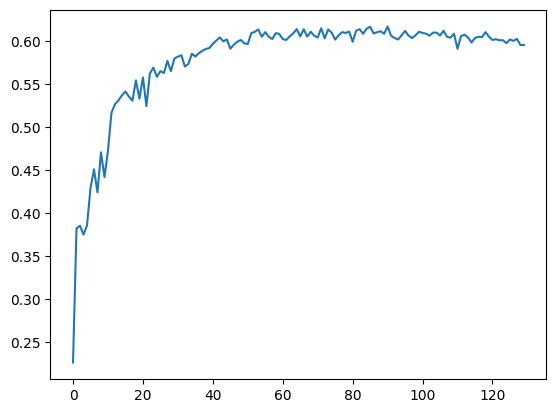

In [ ]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
res = ddq_model.eval(dataset= test_dataset)
res

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
preds = ddq_model.predictOnDataset(dataset= test_dataset)
preds = np.array(preds)[:,0]
labels = list(map(lambda x : x["label"], test_dataset))

In [ ]:
preds[(preds == -1)] = 0

In [ ]:
test_dataset.label_to_index

{'BROWSERS': 0, 'P2P': 1, 'OTHER': 2, 'Skype': 3, 'MAIL': 4}

In [ ]:


confusion_matrix(y_true= labels,y_pred= preds)

array([[1796,    6,  302,  347,    6],
       [  23, 2398,   17,    8,    8],
       [ 501,   10, 1258,  209,   21],
       [ 195,   12,   63, 1811,    3],
       [  66,   13,   22,   16, 1113]])

In [ ]:
test_dataset.label_to_index
index_to_label = {x:y for y,x in test_dataset.label_to_index.items()}

In [ ]:
labels = np.array(test_dataset.get_labels())
unique_labels = np.unique(labels)
res = ddq_model.predictOnDataset(test_dataset)
res = np.array(res)[:,1]

In [ ]:
ut_dct = dict()
for label in unique_labels:
    ut_dct[index_to_label[label]] =  res[labels == label].mean()

In [ ]:
ut_dct

{'google-maps': 9.732919254658386,
 'youtube': 11.95539033457249,
 'instagram': 12.003968253968255,
 'pinterest': 9.855371900826446,
 'spotify': 11.63953488372093,
 'facebook': 11.846456692913385,
 'google-drive': 8.884146341463415,
 'twitter': 10.19186046511628,
 'netflix': 9.655581947743467,
 'reddit': 11.238235294117647,
 'hangout': 8.974025974025974,
 'messenger': 12.655913978494624,
 'gmail': 11.673684210526316}

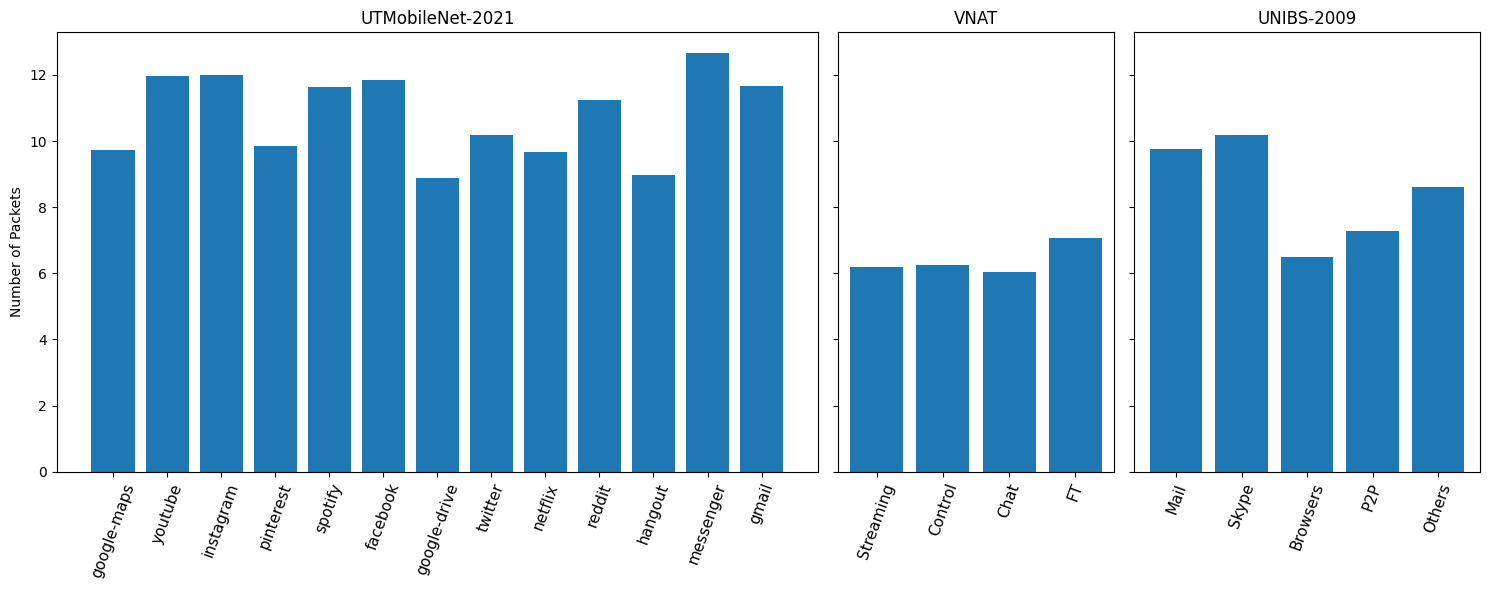

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def getDataDct(dct):
    X,y = [],[]
    for key,value in dct.items():
        X.append(key)
        y.append(value)
    return X,y
# Sample data for 4 datasets, each containing classes and corresponding values
class_data = {
    'UTMobileNet-2021': ut_dct,
    'VNAT': {'Streaming': 6.19, 'Control': 6.25, 'Chat': 6.05, 'FT': 7.07},
    'UNIBS-2009': {'Mail': 9.75, 'Skype': 10.17, 'Browsers': 6.48, 'P2P': 7.28, 'Others': 8.62},
}



f, axes = plt.subplots(1, len(class_data), sharex='col', sharey='row', figsize=(15, 6),gridspec_kw={'width_ratios':[11,4,5]})

for i,dataset in enumerate(class_data):
    X,y = getDataDct(class_data[dataset])
    axes[i].bar(X,y)
    axes[i].set_title(dataset)
    axes[i].tick_params(axis='x', rotation=70,labelsize = 11)
    if i == 0:
        axes[i].set_ylabel('Number of Packets')  # Set y-axis label



plt.tight_layout()
plt.show()


In [ ]:
res[labels == 0].mean()

9.732919254658386

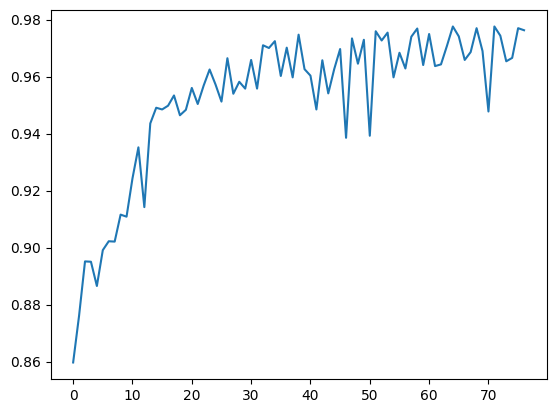

In [ ]:
plt.plot(logger.getMetric("test_eval_f1"))

In [ ]:
np.argmax(np.array(logger.getMetric(metric_name= "test_eval_f1")))

64

In [ ]:
logger.getMetric(metric_name= "test_eval_time")[64]

7.814477468839885

In [ ]:
logger.getMetric(metric_name= "test_eval_f1")[64]

0.9775886864813039